In [12]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [45]:
data_dir = './'
data_file = 'Aggregation.txt'

In [46]:
df = pd.read_csv(os.path.join(data_dir, data_file), sep=' ')
df.head(3)

,x,y,tag
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2


<Axes: xlabel='x', ylabel='y'>

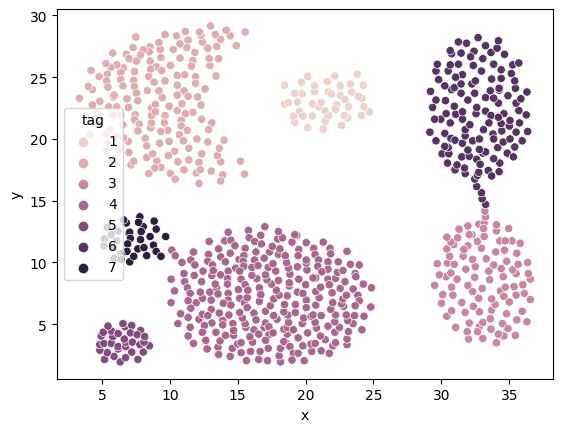

In [47]:
sns.scatterplot(data=df, x="x", y="y", hue="tag")

In [48]:
X_0 = df['x'].tolist()
X_1 = df['y'].tolist()
X = np.column_stack((X_0, X_1))
y = df['tag'].tolist()

In [49]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, _ = train_test_split(X, y, test_size=0.7, random_state=42, shuffle=True)

In [154]:
# Train RandomForest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_X, train_y)
probabilities = clf.predict_proba(X)
probabilities_train = clf.predict_proba(train_X)
predicted_classes = clf.predict(X)

In [259]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(train_X, train_y)
probabilities = clf.predict_proba(X)
probabilities_train = clf.predict_proba(train_X)
predicted_classes = clf.predict(X)

In [260]:
df["predicted"] = predicted_classes
df["miss"] = df.apply(lambda row: (row['tag'] == row["predicted"]), axis=1).values
df["miss_c"] = [0 if v else 1 for v in df["miss"].values]
df["p"] = np.max(probabilities, axis=1)

In [251]:
# RMD

from tool.core.ood_score import ood_relative_mahalanobis_distance

bayes = False
relative = False
ood_score = ood_relative_mahalanobis_distance.rmd(train_X, train_y, X, relative=relative, bayes=bayes)

In [256]:
# KNN Distance

from tool.core.ood_score import ood_confident_learning
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()
ood.fit_score(features=train_X)
ood_score = ood.score(features=X)
ood_score = np.subtract(1.0, ood_score)

Fitting OOD estimator based on provided features ...


In [234]:
# Entropy

from tool.core.ood_score.ood_entropy.ood import OoD

ood = OoD(regularization_coefficients={1e-5, 1e-3, 1.0, 1e3, 1e5})
ood_score = ood.fit_and_score([train_X], train_y, [X])

/home/vlasova/Desktop/gitlab/oodtool/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vlasova/Desktop/gitlab/oodtool/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vlasova/Desktop/gitlab/oodtool/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vlasova/Desktop/gitlab/oodtool/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vlasova/Desktop/gitlab/oodtool/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [265]:
# Score probailities

from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()
ood.fit_score(pred_probs=probabilities_train, labels=np.subtract(train_y, 1.0))
ood_predictions_scores = ood.score(pred_probs=probabilities)
ood_score = np.subtract(1.0, ood_predictions_scores)

Fitting OOD estimator based on provided pred_probs ...


/tmp/ipykernel_649946/1500569482.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  p = plt.cm.get_cmap('jet') # sns.color_palette("Spectral", as_cmap=True)


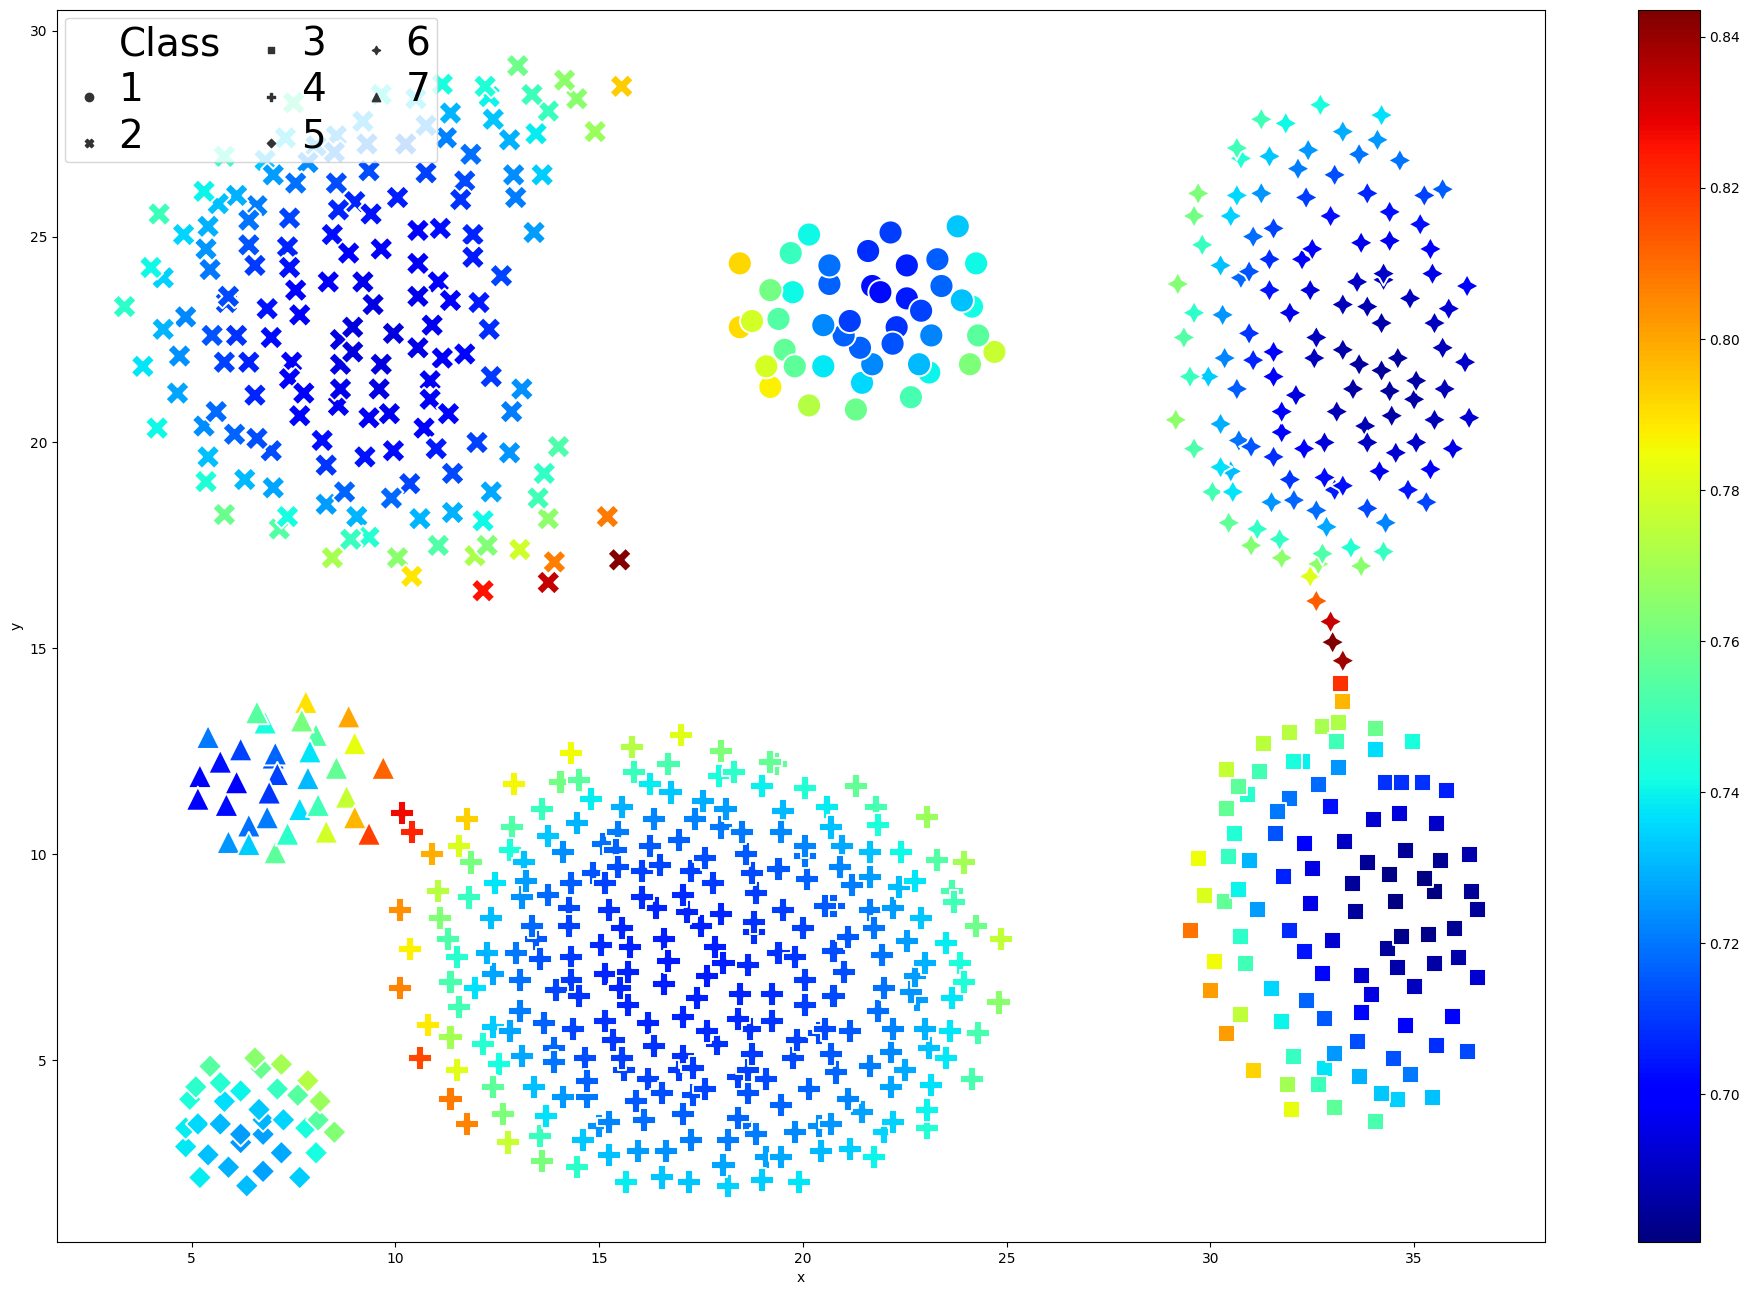

In [267]:
df["ood"] = ood_score
df["Class"] = df["tag"]
df["prediction"] = ["correct" if v else "missclassified" for v in df["miss"].values]
df["max probability"] = df["p"]

a4_dims = (24, 16)
fig, ax = plt.subplots(figsize=a4_dims)

p = plt.cm.get_cmap('jet') # sns.color_palette("Spectral", as_cmap=True)
# p.reverse()
norm = plt.Normalize(df['ood'].min(), df['ood'].max())
sm = plt.cm.ScalarMappable(cmap=p, norm=norm)
sns.scatterplot(ax=ax, data=df, x="x", y="y", style="Class", hue='ood', s=300, palette=p, legend = 'brief')
# sns.scatterplot(ax=ax, data=df, x="x", y="y", style="prediction", hue='max probability', s=300, palette=p, legend = 'brief')

# plt.legend([],[], frameon=False)
# plt.legend(loc=1)
# plt.legend(['1', '2', '3', '4', '5', '6', '7'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(ncol=3, fontsize='large', loc='upper left', markerfirst=True, shadow=False, handles=handles[7:],
           labels=labels[7:])
plt.setp(ax.get_legend().get_texts(), fontsize='28')
ax.figure.colorbar(sm, ax=ax)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
from matplotlib import pyplot as plt
sns.set()

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(24,16))

coef = [0.01, 1.0, 100.0]
x_min = np.min(X[:, 0]) - .5
x_max = np.max(X[:, 0]) + .5
x_clf = np.arange(x_min, x_max, 0.1, dtype=float)

y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
y_clf = np.arange(y_min, y_max, 0.1, dtype=float)

h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

df_df = pd.DataFrame()

XX = np.c_[xx.ravel(), yy.ravel()]
df_df['xx'] = XX[:, 0] 
df_df['yy'] = XX[:, 1]

for idx, c in enumerate(coef):
    clf = LogisticRegression(random_state=42, C=c, solver='liblinear', max_iter=1000)
    clf.fit(train_X, train_y)
    tag_pred = 'tag' + str(c) 
    tag_prob = 'prob' + str(c) 
    prob = clf.predict_proba(X)
    df[tag_prob] = np.max(prob, axis=1)
    df[tag_pred] = np.argmax(prob, axis=1)
    row_idx = int(idx / n_cols)
    c_idx = idx % n_cols
    tag_back = 'back' + str(c) 
    predicted_proba = clf.predict_proba(XX)
    df_df[tag_back] = np.max(predicted_proba, axis=1)
    # print(clf.coef_, clf.intercept_)
    sns.scatterplot(ax=axes[row_idx, c_idx], data=df_df, x="xx", y="yy", hue=tag_back)
    sns.scatterplot(ax=axes[row_idx, c_idx], data=df, x="x", y="y", hue=tag_pred)

Error in callback <function _draw_all_if_interactive at 0x7f7c95f1aaf0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f7c6b79bdc0> (for post_execute):


KeyboardInterrupt: 

In [33]:
from matplotlib import pyplot as plt
sns.set()

coef = [0.001, 1.0, 1000.0]

x_min, x_max = np.min(X[:, 0]) - 1.0, np.max(X[:, 0]) + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

df_df = pd.DataFrame()

XX = np.c_[xx.ravel(), yy.ravel()]
df_df['xx'] = XX[:, 0] 
df_df['yy'] = XX[:, 1]

df_df['tag_mean'] = np.ones((XX.shape[0],))

# sns.set_style(style='white')

mean_prob = np.ones((X.shape[0], 2))

for idx, c in enumerate(coef):
    clf = LogisticRegression(random_state=42, C=c, solver='liblinear', max_iter=1000)
    clf.fit(train_X, train_y)
    tag_back = 'back' + str(c) 
    predicted_proba = clf.predict_proba(XX)
    predicted_proba_data = clf.predict_proba(X)
    mean_prob += predicted_proba_data
    df_df[tag_back] = np.max(predicted_proba, axis=1)
    df_df['tag_mean'] = df_df[[tag_back,'tag_mean']].min(axis=1)
    # print(clf.coef_, clf.intercept_)
    


In [34]:
mean_prob

array([[1.21811618, 3.78188382],
       [1.4154029 , 3.5845971 ],
       [1.59322325, 3.40677675],
       [2.14319145, 2.85680855],
       [1.6398071 , 3.3601929 ],
       [1.61249217, 3.38750783],
       [1.30193972, 3.69806028],
       [1.27079343, 3.72920657],
       [1.23979127, 3.76020873],
       [1.20374515, 3.79625485],
       [1.17106047, 3.82893953],
       [1.16414717, 3.83585283],
       [1.17614206, 3.82385794],
       [1.21533254, 3.78466746],
       [2.20761735, 2.79238265],
       [1.59546651, 3.40453349],
       [1.32195169, 3.67804831],
       [1.27603121, 3.72396879],
       [1.23357403, 3.76642597],
       [1.20338864, 3.79661136],
       [1.22269905, 3.77730095],
       [1.20462955, 3.79537045],
       [1.17377745, 3.82622255],
       [1.1576491 , 3.8423509 ],
       [1.1588838 , 3.8411162 ],
       [1.17637568, 3.82362432],
       [1.18893485, 3.81106515],
       [1.21679854, 3.78320146],
       [1.29693786, 3.70306214],
       [1.3034896 , 3.6965104 ],
       [1.

In [35]:
from scipy.stats import entropy

def calculate_entropy(mean_dist):
    return entropy(mean_dist)

score = np.apply_along_axis(calculate_entropy, axis=1, arr=mean_prob)

In [36]:
score.shape

(373,)

In [37]:
df

,x,y,tag,prob0.01,tag0.01,prob1.0,tag1.0,prob100.0,tag100.0,score
0,0.85,17.45,2,0.968486,1,0.989493,1,0.964731,1,0.555220
1,0.75,15.60,2,0.955312,1,0.980606,1,0.824590,1,0.595839
2,3.30,15.45,2,0.927275,1,0.962702,1,0.732027,1,0.625844
3,5.25,14.20,2,0.871685,1,0.912137,1,0.622579,0,0.682927
4,4.90,15.65,2,0.907379,1,0.949390,1,0.720470,1,0.632726
...,...,...,...,...,...,...,...,...,...,...
368,38.75,16.85,1,0.980525,0,0.992454,0,0.960618,0,0.532872
369,39.00,16.60,1,0.982332,0,0.993486,0,0.969924,0,0.529414
370,38.25,17.35,1,0.976350,0,0.989879,0,0.933136,0,0.542758
371,39.50,16.95,1,0.982727,0,0.993482,0,0.961414,0,0.531350


In [38]:
df['score'] = score

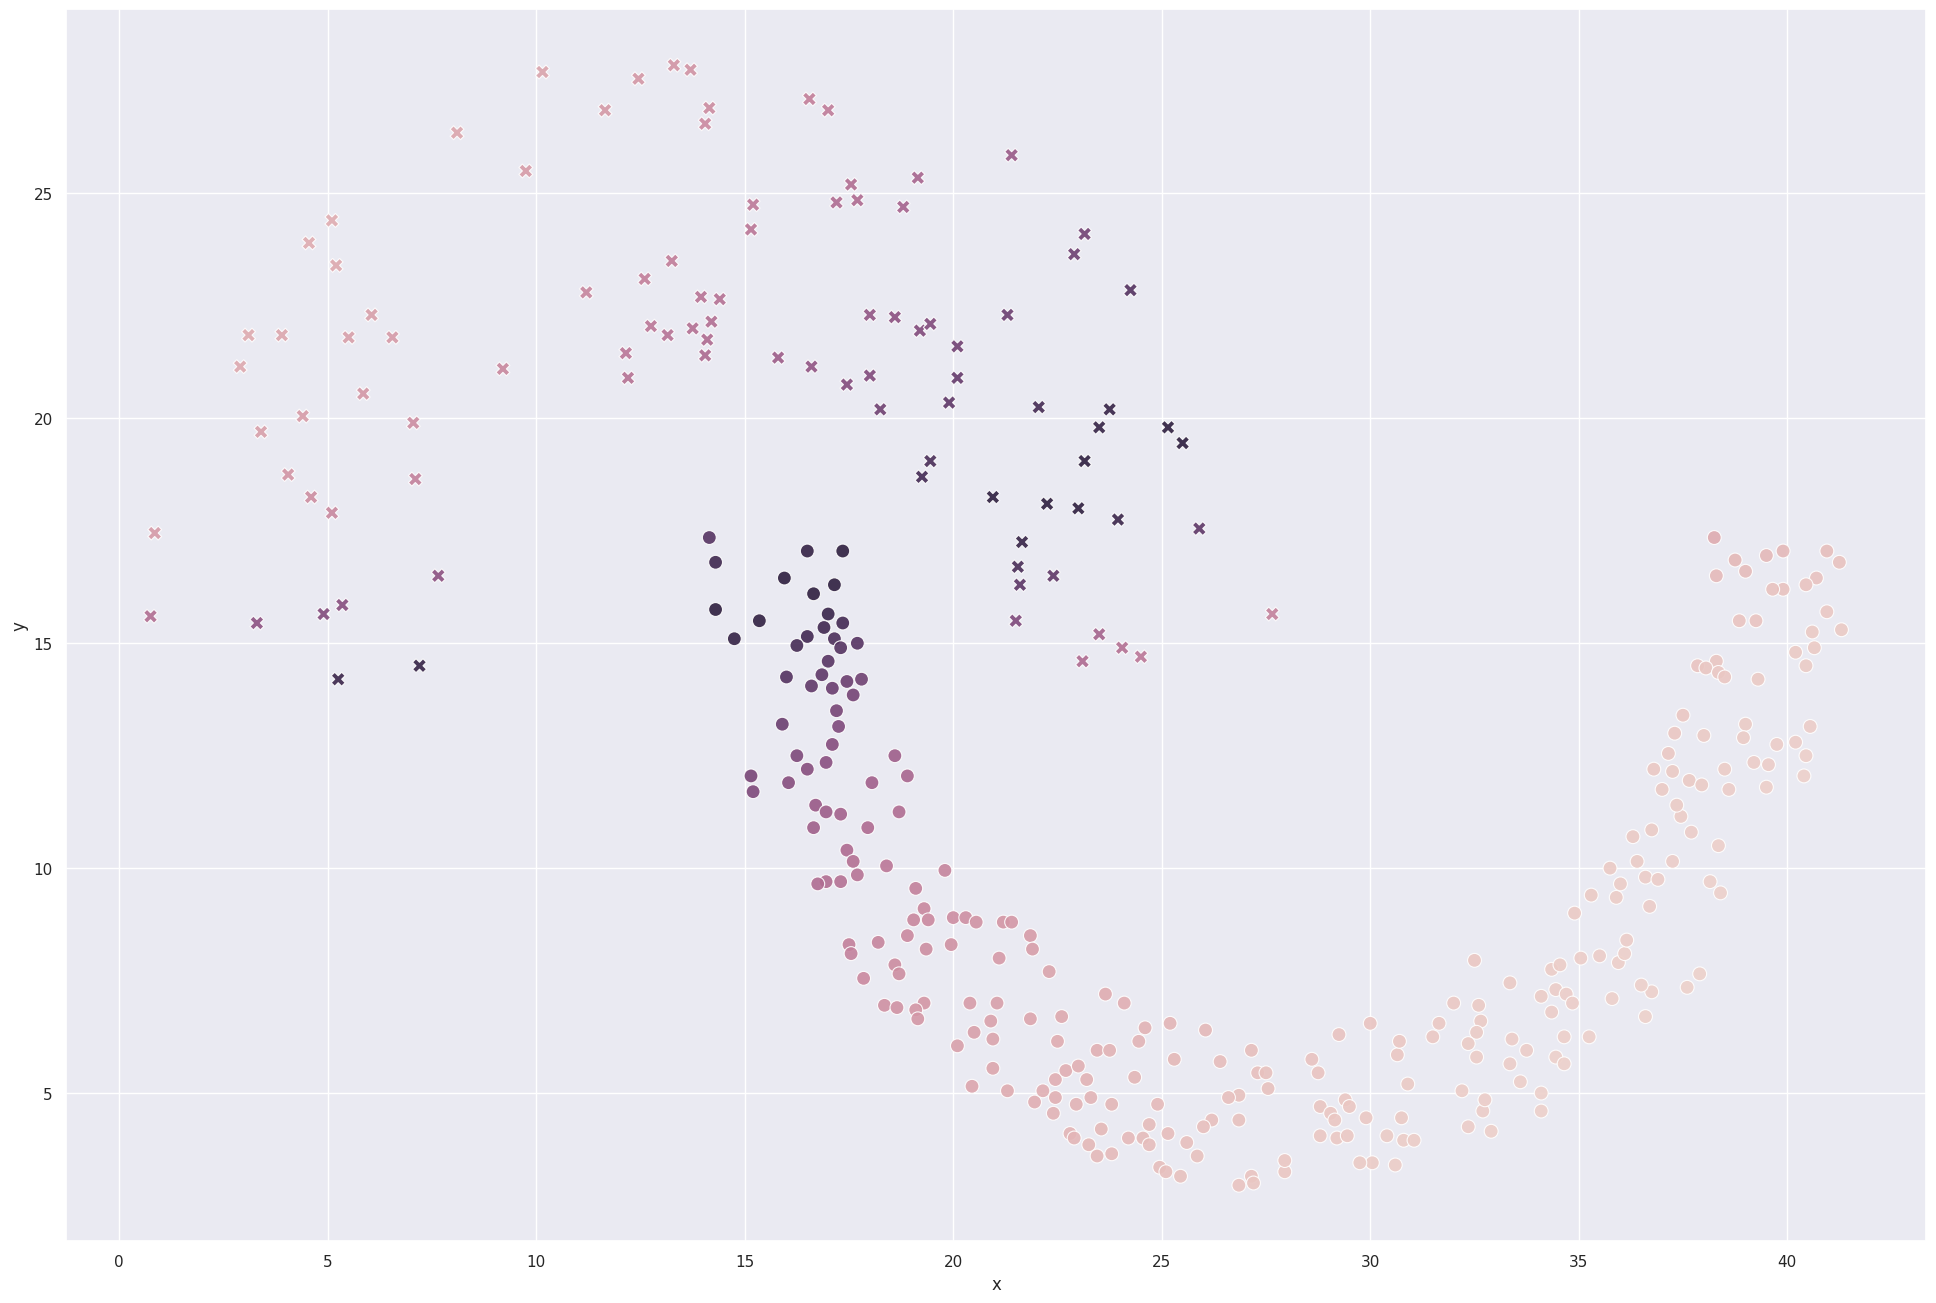

In [23]:
a4_dims = (24, 16)
fig, ax = plt.subplots(figsize=a4_dims)

sns.scatterplot(ax=ax, data=df, x="x", y="y", hue='score', style="tag", alpha = 0.9, s=100)

plt.legend([],[], frameon=False)

In [ ]:
a4_dims = (32, 24)
fig, ax = plt.subplots(figsize=a4_dims)

p = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
p2 = sns.color_palette("flare", as_cmap=True)
sns.scatterplot(ax=ax, data=df_df, x="xx", y="yy", hue='tag_mean', alpha=0.4, palette=p)  
sns.scatterplot(ax=ax, data=df, x="x", y="y", hue='score', style="tag", alpha = 0.9, s=200, palette=p2)

plt.legend([],[], frameon=False)

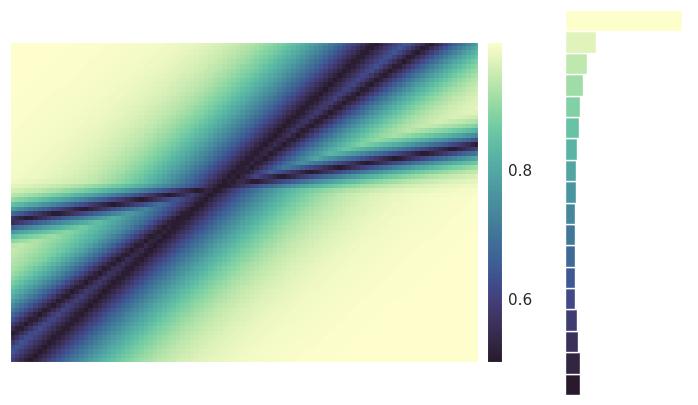

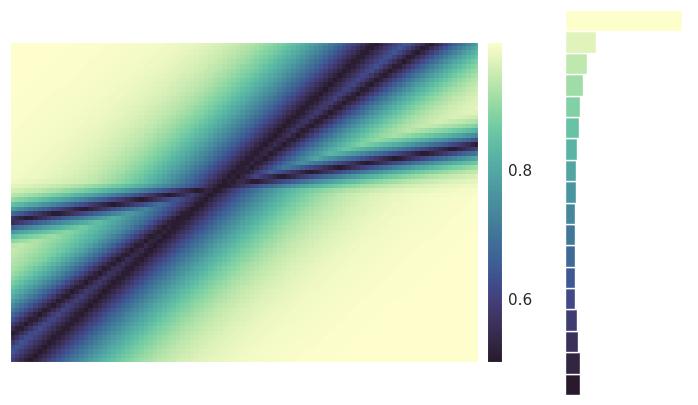

In [57]:
import seaborn_image as isns

isns.imghist(img)

In [41]:
yy.shape

(70, 102)

In [56]:
img = df_df['tag_mean'].to_numpy().reshape((70, 102))

In [54]:
7140/ 35

204.0

In [47]:
x_max - x_min

50.55

In [48]:
y_max - y_min

34.9

In [51]:
35*51*4

7140